# Übungsblatt 12
## Präsenzaufgaben
### Aufgabe 1 &nbsp;&nbsp;&nbsp; Evaluationsmetriken

In [1]:
from sklearn.metrics import accuracy_score, precision_score,\
    recall_score, f1_score

Betrachten Sie folgende Daten. Es handelt sich um ein vereinfachtes Tagging-Schema fürs Chunking, bei dem nur zwischen „Teil einer NP“ (`1`) und „nicht Teil einer NP“ (`0`) unterschieden wird.

In [2]:
ground_truth = [1,0,1,0,0,1,1,1,1,0]
chunker1     = [1,1,1,0,1,0,1,1,1,1]
chunker2     = [1,0,1,0,0,0,0,0,1,0]
chunker3     = [0,0,0,0,0,1,1,1,1,0]

Berechnen Sie für jeden der Chunker Accuracy, Precision, Recall und F1-Score zunächst per Hand und überprüfen Sie dann Ihr Ergebnis.

In [3]:
def evaluate(chunker):
    print(
        "Accuracy:",
        "{:.2f}".format(accuracy_score(ground_truth, chunker))
    )
    print(
        "Precision:",
        "{:.2f}".format(precision_score(ground_truth, chunker))
    )
    print(
        "Recall:",
        "{:.2f}".format(recall_score(ground_truth, chunker))
    )
    print(
        "F1-Score:",
        "{:.2f}".format(f1_score(ground_truth, chunker))
    )

In [ ]:
evaluate(chunker1)

In [ ]:
evaluate(chunker2)

In [ ]:
evaluate(chunker3)

### Aufgabe 2 &nbsp;&nbsp;&nbsp; Herunterladen von Ressourcen

Das CoNLL 2000 Korpus ist ein POS- und Chunk-getaggtes Korpus (IOB- Format), das
in ein Test- und ein Trainingskorpus aufgeteilt ist. Wir werden es zum Training und zur
Evaluation von Chunk-Parsern verwenden. Laden Sie es sich dafür zunächst über die
Ressource `corpora/conll2000` herunter.

In [4]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Wenn Sie es erfolgreich heruntergeladen haben, können Sie folgendermaßen darauf zugrei-
fen:

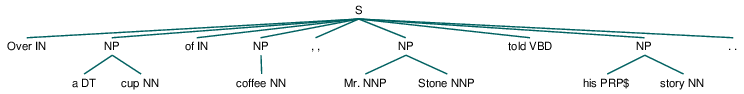

In [5]:
from nltk.corpus import conll2000
conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99]

Das `chunk_types`-Argument dient der Auwahl von Chunk-Typen (in diesem Beispiel
Nominalphrasen).

### Aufgabe 3 &nbsp;&nbsp;&nbsp; Chunking mit regulären Ausdrücken

Erstellen Sie einen einfachen `RegexpParser`, der für Nominalphrasen charakteristische
Tags zu NPs zusammenfasst. Solche charakteristischen Tags sind z.B. Kardinalzahlen (`CD`),
Artikel (`DT`), Adjektive (`JJ`, `JJR`, `JJS`) und natürlich Substantive (`NN`, `NNS`, `NNP`, `NNPS`).

Weitere interessante Tags wären `PDT` (z.B. *both*, *a lot of*), `POS` (*'s*), `PRP` (Personalpronomen), `PRP$` (Possessivpronomen).

In [6]:
regex = r""

Evaluieren Sie Ihren Parser anschließend auf dem CoNLL 2000 Korpus:

In [7]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
cp = nltk.RegexpParser(regex)
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


### Aufgabe 4 &nbsp;&nbsp;&nbsp; Datenbasiertes Chunking

(a) Betrachten Sie den folgenden Code für einen Chunker, der für jedes POS-Tag das
wahrscheinlichste Chunk-Tag berechnet (Training) und dieses dann zur Testzeit
ausgibt.

In [8]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [
            [
                (t,c)
                for w,t,c in nltk.chunk.tree2conlltags(sent)
            ]
            for sent in train_sents
        ]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [
            chunktag for (pos, chunktag) in tagged_pos_tags
        ]
        conlltags = [
            (word, pos, chunktag)
            for ((word, pos), chunktag)
            in zip(sentence, chunktags)
        ]
        return nltk.chunk.conlltags2tree(conlltags)

Trainieren und evaluieren Sie den UnigramChunker auf dem CoNLL 2000 Korpus.

In [9]:
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
# uc = ...

Um uns einen Überblick darüber zu verschaffen, was der Chunker gelernt hat, können wir ihn für jedes mögliche POS-Tag eine Vorhersage treffen lassen:

In [10]:
postags = sorted(set(pos for sent in train_sents for (word,pos) in sent.leaves()))
# uc.tagger.tag(postags)

(b) Der `ConsecutiveNPChunker`, dessen Code Sie in der nächsten Zelle sehen, basiert auf einem Klassifikator.

In [11]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents, npchunk_features):
        self.extract_features = npchunk_features
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = self.extract_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents, npchunk_features):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents, npchunk_features)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

Dies erlaubt uns, die Features, die für die Klassifikation extrahiert werden, genauer zu bestimmen.

Ein Feature-Extraktor lässt sich als Funktion z.B. so definieren:

In [12]:
def pos_feature(sentence , i, history):
    word, pos = sentence[i]
    return {"pos": pos}

Dieser Feature-Extraktor extrahiert genau ein Feature, nämlich das POS-Tag, das
auch der UnigramChunker verwendet hat.

Evaluieren Sie den `ConsecutiveNPChunker` mit diesem Feature-Extraktor und vergleichen Sie seine Performanz mit der des `UnigramChunker`s.

In [13]:
chunker = ConsecutiveNPChunker(train_sents, pos_feature)
# TODO: code for evaluation

(c) Fügen Sie weitere Features für
- das aktuelle Wort,
- das vorhergehende POS-Tag und
- das vorhergehende Chunk-Tag

zur Extraktion hinzu und beobachten Sie jeweils die Auswirkungen auf die Performanz in der Evaluation.

In [14]:
def word_feature(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

def previous_pos(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

def previous_chunk(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, word_feature)
print(chunker.evaluate(test_sents))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, previous_pos)
print(chunker.evaluate(test_sents))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, previous_chunk)
print(chunker.evaluate(test_sents))

## Hausaufgaben
### Aufgabe 5 &nbsp;&nbsp;&nbsp; Feature Engineering
Anschließend an Aufgabe 4 sollen Sie hier weitere Features implementieren und jeweils deren Auswirkungen auf die Performanz beobachten.

Fügen Sie von oben nach unten immer jeweils ein neues Feature nach dem anderen hinzu
und behalten Sie alle bisherigen Features bei. Dann notieren Sie jeweils den Performanz-
gewinn (oder -verlust) im Vergleich zur vorherigen Zeile in untenstehender Tabelle.
Fügen Sie außerdem noch zwei neue Features an das Ende der Tabelle, die Sie sich selbst
ausdenken!

Zum Schluss können Sie auch eine sogenannte ablation study durchführen. Dabei wird
immer genau eines der Features entfernt, um anhand des Performanzverlustes dessen
Beitrag zum Ergebnis zu bemessen.

| Neues Feature                                                   | Performanzgewinn (F1) | Ablation Study |
|-----------------------------------------------------------------|-----------------------|----------------|
| Lookahead: nächstes POS-Tag                                     |                       |                |
| Paar-Feature: vorhergehendes und aktuelles POS-Tag konkateniert |                       |                |
| Paar-Feature: aktuelles und nächstes POS-Tag konkateniert       |                       |                |
| Lookahead: nächstes Wort                                        |                       |                |
| (Sortierte) Menge aller POS-Tags seit dem Artikel (`DT`)        |                       |                |
|                                                                 |                       |                |
|                                                                 |                       |                |

In [ ]:
def next_pos(sentence, i, history):
    word, pos = sentence[i]
    return {
        "pos": pos
    }

def prevcur_pos(sentence, i, history):
    word, pos = sentence[i]
    return {
        "pos": pos
    }

def curnext_pos(sentence, i, history):
    word, pos = sentence[i]
    return {
        "pos": pos
    }

def next_word(sentence, i, history):
    word, pos = sentence[i]
    return {
        "pos": pos
    }

def tags_since_dt(sentence, i, history):
    def tags_since_dt_helper(sentence, i):
        tags = set()
        return '+'.join(sorted(tags))
    
    word, pos = sentence[i]
    return {
        "pos": pos,
        "tags-since-dt": tags_since_dt_helper(sentence, i)
    }

#### Features schrittweise hinzufügen

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, next_pos)
print(chunker.evaluate(test_sents))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, prevcur_pos)
print(chunker.evaluate(test_sents))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, curnext_pos)
print(chunker.evaluate(test_sents))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, next_word)
print(chunker.evaluate(test_sents))

In [ ]:
chunker = ConsecutiveNPChunker(train_sents, tags_since_dt)
print(chunker.evaluate(test_sents))

#### Ablation Study

In [ ]:
def ablate(feat_extr, feat_name):
    def ablated_feat_extr(sentence, i, history):
        feat_dict = feat_extr(sentence, i, history)
        feat_dict.pop(feat_name, None)
        return feat_dict
    return ablated_feat_extr

In [ ]:
# in diese Liste sind die Namen der Features einzutragen, die oben jeweils vergeben wurden
for feat_name in []:
    print("Ablated Feature:", feat_name)
    feature_extractor = ablate(tags_since_dt, feat_name)
    chunker = ConsecutiveNPChunker(train_sents, feature_extractor)
    print(chunker.evaluate(test_sents))